# Medical Diagnosis with Machine Learning

In [1]:
!pip install scikit-learn pandas joblib matplotlib


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### Imports and configuration

In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import joblib
import matplotlib.pyplot as plt

RANDOM_STATE = 42

### Load dataset

In [4]:
DATA_PATH = 'healthcare_dataset.csv' 
df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (55500, 15)


,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


### Quick EDA and target inspection

In [5]:
# Basic info
print(df.info())
print(df.isnull().sum())

# Inspect target distribution
print("Unique medical conditions:", df['Medical Condition'].nunique())
print(df['Medical Condition'].value_counts(normalize=True).mul(100).round(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                55500 non-null  object 
 1   Age                 55500 non-null  int64  
 2   Gender              55500 non-null  object 
 3   Blood Type          55500 non-null  object 
 4   Medical Condition   55500 non-null  object 
 5   Date of Admission   55500 non-null  object 
 6   Doctor              55500 non-null  object 
 7   Hospital            55500 non-null  object 
 8   Insurance Provider  55500 non-null  object 
 9   Billing Amount      55500 non-null  float64
 10  Room Number         55500 non-null  int64  
 11  Admission Type      55500 non-null  object 
 12  Discharge Date      55500 non-null  object 
 13  Medication          55500 non-null  object 
 14  Test Results        55500 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 6.4

### Feature engineering (length of stay) and initial cleanup

In [6]:
# Parse dates and compute length of stay where possible
def parse_date_safe(x):
    try:
        return pd.to_datetime(x)
    except:
        return pd.NaT

df['Date of Admission'] = df['Date of Admission'].apply(parse_date_safe)
df['Discharge Date'] = df['Discharge Date'].apply(parse_date_safe)
df['Length_of_Stay_days'] = (df['Discharge Date'] - df['Date of Admission']).dt.days

# Replace negative or impossible lengths with NaN
df.loc[df['Length_of_Stay_days'] < 0, 'Length_of_Stay_days'] = np.nan

# Drop columns that are identifiers or not useful for modeling
drop_cols = ['Name', 'Doctor', 'Hospital', 'Insurance Provider', 'Room Number', 'Medication', 'Date of Admission', 'Discharge Date']
for c in drop_cols:
    if c in df.columns:
        df = df.drop(columns=c)

print("Remaining columns:", df.columns.tolist())

Remaining columns: ['Age', 'Gender', 'Blood Type', 'Medical Condition', 'Billing Amount', 'Admission Type', 'Test Results', 'Length_of_Stay_days']


### Handle missing values and simple imputations

In [7]:
# Numerical columns: Age, Billing Amount, Length_of_Stay_days
num_cols = ['Age', 'Billing Amount', 'Length_of_Stay_days']
for c in num_cols:
    if c in df.columns:
        median_val = df[c].median()
        df[c] = df[c].fillna(median_val)

# Categorical columns: Gender, Blood Type, Admission Type, Test Results
cat_cols = [c for c in ['Gender', 'Blood Type', 'Admission Type', 'Test Results'] if c in df.columns]
for c in cat_cols:
    df[c] = df[c].fillna('Unknown')

print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
Age                    0
Gender                 0
Blood Type             0
Medical Condition      0
Billing Amount         0
Admission Type         0
Test Results           0
Length_of_Stay_days    0
dtype: int64


### Encode categorical features and prepare X, y

In [8]:
# Target
y = df['Medical Condition'].astype(str).copy()
le_target = LabelEncoder()
y_enc = le_target.fit_transform(y)
print("Target classes:", list(le_target.classes_))

# Prepare features: numeric + one-hot categorical
X = df.drop(columns=['Medical Condition']).copy()

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Ensure numeric dtype for numeric columns
for c in num_cols:
    if c in X.columns:
        X[c] = pd.to_numeric(X[c], errors='coerce')

print("Feature matrix shape:", X.shape)

Target classes: ['Arthritis', 'Asthma', 'Cancer', 'Diabetes', 'Hypertension', 'Obesity']
Feature matrix shape: (55500, 15)


### Train/test split and scaling

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=RANDOM_STATE, stratify=y_enc
)

scaler = StandardScaler()
numeric_in_X = [c for c in num_cols if c in X.columns]
if numeric_in_X:
    X_train[numeric_in_X] = scaler.fit_transform(X_train[numeric_in_X])
    X_test[numeric_in_X] = scaler.transform(X_test[numeric_in_X])

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (44400, 15) Test shape: (11100, 15)


### Train baseline models (Logistic Regression and Random Forest)

In [10]:
# Logistic Regression with class weights
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RANDOM_STATE)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression F1 (macro):", f1_score(y_test, y_pred_lr, average='macro'))

# Random Forest (often stronger)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest F1 (macro):", f1_score(y_test, y_pred_rf, average='macro'))

Logistic Regression Accuracy: 0.1700900900900901
Logistic Regression F1 (macro): 0.16922875999916723
Random Forest Accuracy: 0.29252252252252253
Random Forest F1 (macro): 0.2925156059306229


### Detailed evaluation (best model)

Classification Report for Random Forest:
              precision    recall  f1-score   support

   Arthritis     0.2890    0.2932    0.2911      1862
      Asthma     0.2732    0.2738    0.2735      1837
      Cancer     0.2797    0.2846    0.2821      1845
    Diabetes     0.2949    0.2843    0.2895      1861
Hypertension     0.3101    0.3099    0.3100      1849
     Obesity     0.3085    0.3093    0.3089      1846

    accuracy                         0.2925     11100
   macro avg     0.2926    0.2925    0.2925     11100
weighted avg     0.2926    0.2925    0.2925     11100



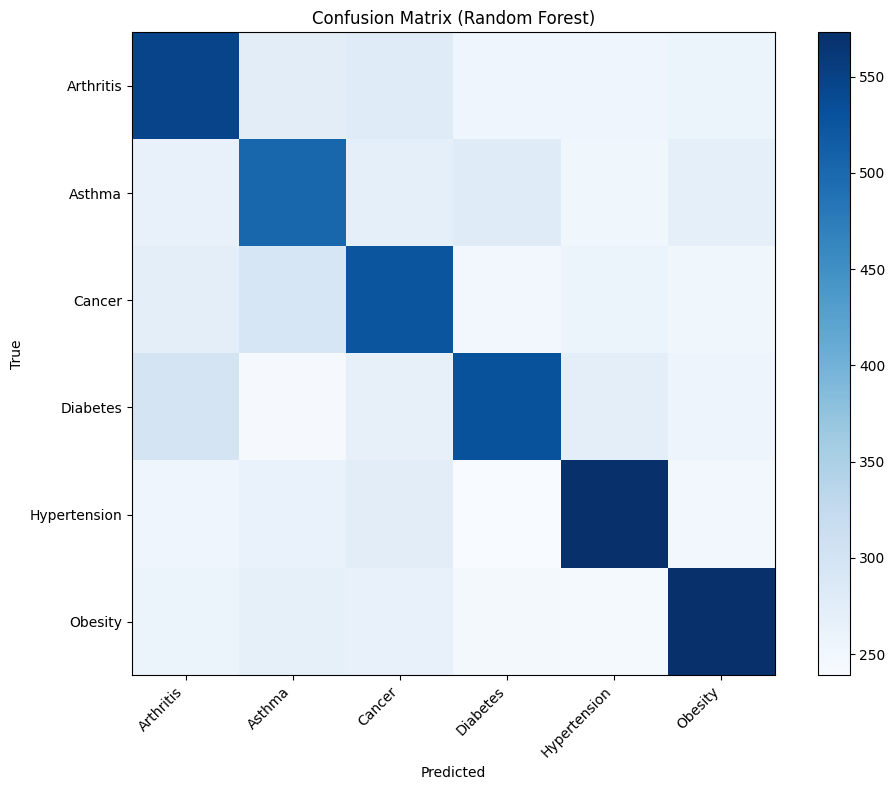

In [11]:
# Choose Random Forest as best model for detailed report (change if you prefer LR)
y_pred = y_pred_rf
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred, target_names=le_target.classes_, digits=4))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (Random Forest)')
plt.colorbar()
tick_marks = np.arange(len(le_target.classes_))
plt.xticks(tick_marks, le_target.classes_, rotation=45, ha='right')
plt.yticks(tick_marks, le_target.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

### Cross-validated score

In [14]:
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
print("Random Forest CV f1_macro scores:", cv_scores)
print("Mean CV f1_macro:", cv_scores.mean())

Random Forest CV f1_macro scores: [0.27256862 0.26226491 0.27043979 0.26917705 0.26680894]
Mean CV f1_macro: 0.26825186215772784


### Save the best model and preprocessing artifacts

In [15]:
MODEL_PATH = 'medical_diagnosis_rf.joblib'
SCALER_PATH = 'medical_scaler.joblib'
LABELENC_PATH = 'medical_label_encoder.joblib'

joblib.dump(rf, MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)
joblib.dump(le_target, LABELENC_PATH)

print("Saved model to:", MODEL_PATH)
print("Saved scaler to:", SCALER_PATH)
print("Saved label encoder to:", LABELENC_PATH)

Saved model to: medical_diagnosis_rf.joblib
Saved scaler to: medical_scaler.joblib
Saved label encoder to: medical_label_encoder.joblib


### Inference helper: predict from a patient record (dict or DataFrame row)

In [16]:
def predict_medical_condition(patient_record, model_path=MODEL_PATH, scaler_path=SCALER_PATH, labelenc_path=LABELENC_PATH):
    """
    patient_record: dict of feature_name -> value or a single-row DataFrame with same columns as X before get_dummies.
    Returns: predicted class label (string) and probability estimates dict for top classes.
    """
    # Load artifacts
    model = joblib.load(model_path)
    scaler_local = joblib.load(scaler_path)
    le_local = joblib.load(labelenc_path)

    # If dict provided, convert to DataFrame
    if isinstance(patient_record, dict):
        row = pd.DataFrame([patient_record])
    else:
        row = patient_record.copy()

    # Ensure all columns present: start from X.columns saved earlier
    # Reconstruct same preprocessing: fill missing numeric/categorical with defaults
    # Numeric fill
    for c in num_cols:
        if c not in row.columns:
            row[c] = df[c].median()
    for c in cat_cols:
        if c not in row.columns:
            row[c] = 'Unknown'

    # One-hot encode with same columns as training set
    row_enc = pd.get_dummies(row, columns=cat_cols, drop_first=True)

    # Add missing columns that were in training
    for col in X.columns:
        if col not in row_enc.columns:
            row_enc[col] = 0
    # Keep only training columns order
    row_enc = row_enc[X.columns]

    # Scale numeric
    if numeric_in_X:
        row_enc[numeric_in_X] = scaler_local.transform(row_enc[numeric_in_X])

    probs = None
    if hasattr(model, "predict_proba"):
        probs_arr = model.predict_proba(row_enc)[0]
        probs = {le_local.inverse_transform([i])[0]: float(probs_arr[i]) for i in range(len(probs_arr))}
    pred_idx = int(model.predict(row_enc)[0])
    pred_label = le_local.inverse_transform([pred_idx])[0]
    return pred_label, probs

# Example usage:
sample = {
    'Age': 45,
    'Gender': 'Female',
    'Blood Type': 'O+',
    'Billing Amount': 12500.0,
    'Admission Type': 'Emergency',
    'Test Results': 'Abnormal',
    'Length_of_Stay_days': 3
}
pred_label, prob_dict = predict_medical_condition(sample)
print("Predicted Medical Condition:", pred_label)
print("Predicted probabilities (top classes):")
print(sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)[:5])

Predicted Medical Condition: Hypertension
Predicted probabilities (top classes):
[('Hypertension', 0.35), ('Cancer', 0.265), ('Diabetes', 0.14), ('Obesity', 0.13), ('Asthma', 0.1)]
